In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from matplotlib.gridspec import GridSpec
from plots.mpltoolkit import named_colors, mpl_loc, fancy_legend, load_mpl_presets, append_axes, markers
import vice
from vice.yields.presets import JW20
import numpy as np
import math as m
import sys
sys.path.append("..")
from utils import exponential
load_mpl_presets()
print(sys.version_info)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)


In [20]:
raw = np.genfromtxt("../data/gsechem.dat")
print(raw.shape)
data = {}
data["[fe/h]"] = raw[:, 0]
data["[fe/h]_err"] = raw[:, 1]
data["[o/fe]"] = raw[:, 2]
data["[o/fe]_err"] = raw[:, 3]

print(data["[fe/h]"][:10])
print(data["[o/fe]"][:10])

(472, 4)
[-1.4871372  -0.83352224 -1.3056721  -1.3754318  -1.0839403  -0.86073018
 -1.6437197  -1.0283155  -1.7468884  -1.831019  ]
[0.3841143  0.24181838 0.33067891 0.30600873 0.2341942  0.1250261
 0.24496079 0.11081072 0.29841003 0.22635898]


Median [Fe/H] error: 0.0585
Median [O/Fe] error: 0.0567


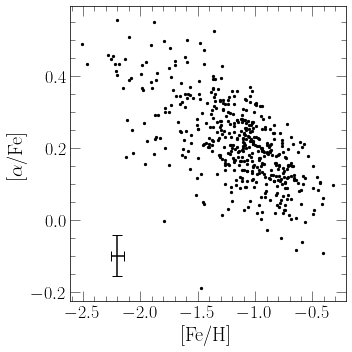

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")

med_ofe_err = np.median(data["[o/fe]_err"])
med_feh_err = np.median(data["[fe/h]_err"])
print("Median [Fe/H] error: %.4f" % (med_feh_err))
print("Median [O/Fe] error: %.4f" % (med_ofe_err))
kwargs = {
#     "s": 5,
    "c": named_colors()["black"],
    "xerr": med_feh_err,
    "yerr": med_ofe_err,
    "linestyle": "None"
}
ax.errorbar(-2.2, -0.1, **kwargs)
# ax.errorbar(data["[fe/h]"], data["[o/fe]"], **kwargs)
del kwargs["xerr"]
del kwargs["yerr"]
del kwargs["linestyle"]
kwargs["s"] = 5
ax.scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)

plt.tight_layout()
plt.show()